# CASE 2. Classifier for detection of pneumonia using convolutional neural networks for inbalanced data

TEAM 10: 
Eliecer Diaz, Muskan Kaushik, and Zakaria Hasan

I. Background

Convolutional neural networks, so-called convnets (CNN) are essential for providing understnading on how humans may recognize images, and also providing insights on computer vision implementations.

Convolutional networks are a type of algorithm used to classify images, it is surprisingly simple, although the adjustments and effective architectures used can become complex. The idea behind is that the basic unit of input data comprises a 2D dimensional array, which can contain 1-3 or more colour channel. This input imagese passe through a sequence of filters or kernels which extract features from the image to make it classifiable (Chollet 2017).

Objectives:

- To learn to use convnets (CNN) and create a binary classifier for x-ray chest images.
- To build, fit and evaluate three different CNN models and compare their performances using an additional metric different from accuracy, e.g. sensitivity or specificity.
- To select the best model and explain the decision.

II. Methods

a. The dataset was provided by Kermany et al. (2018)from Mandeley Data repository. Dataset contains Chest X-Ray Images, concerning diagnosis of pneumonia. The data was split into a proportion 60:20:20, corresponding to training, validation and testing data by the authors.

b. Data exploration and processing comprised:
    1.  ImageGenerator function used for rescaling each image
    2.  We also used ImageGenerator function to resize each image, to obtain 150 by 150 pixels. 
    3. We shuffled images (except the test set) using Image generator functions.

In [1]:
import random 
import collections
random.seed(7)
import tensorflow as tf
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt
from time import time
import tensorflow.keras.backend as k
import tensorflow.keras.callbacks as Callback
import matplotlib.pyplot as plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# In case we have GPU e.g. Kaggle notebook we use it, otherwise we used CPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found in this computer")
else:
    print("Found GPU at: {}".format(device_name))


GPU device not found in this computer


In [2]:
#The data was read from three directories: train, validation and test # kaggle
train_dir = r'/home/elvi/Desktop/pneumonia2/train' #'/kaggle/input/pneumonia/pneumonia2/train'
val_dir = r'/home/elvi/Desktop/pneumonia2/validation'#'/kaggle/input/pneumonia/pneumonia2/validation'
test_dir = r'/home/elvi/Desktop/pneumonia2/test'#'/kaggle/input/pneumonia/pneumonia2/test'

In [4]:
os.listdir(train_dir)

['PNEUMONIA', 'NORMAL']

Examination of data balance implies to count how many photos 
corresponded to each category in each
directory: 'PNEUMONIA' or 'NORMAL'.

In [5]:
folders = ['train', 'validation', 'test']
for i in folders:
    print(i)
    Pneu = os.listdir('/home/elvi/Desktop/pneumonia2/{}/PNEUMONIA'.format(i)) # dir is your directory path
    Norm = os.listdir('/home/elvi/Desktop/pneumonia2/{}/NORMAL'.format(i)) 
    print(len(Pneu), len(Norm), ", % of sick / total =", 100*(len(Pneu)/(len(Pneu) + len(Norm))))

train
2564 949 , % of sick / total = 72.98605180757187
validation
855 317 , % of sick / total = 72.95221843003414
test
854 317 , % of sick / total = 72.92912040990606


It was possible to observe an imbalance in the data between patients presenting Pneumonia and healthy ones.
This inbalance corresponded to a 73%. This implies that if we pick randomly a 
patient from the dataset, there is 73% of chance that presents Pneumonia.
This creates a benchmark, which needs to be improved by our classifier.

The following code represents the data generator function which helps to process the data, e.g.
rescale, resize images.

In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
        test_dir,
        #verbose = 0,
        shuffle=False,
        target_size = (150, 150),
        batch_size = 1, #<----tensorflow documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
        class_mode='binary')

Found 1171 images belonging to 2 classes.


# CREATING MODELS

Model creation: We have created three models comprising of similar architecture to test the effect of the batch_size. The batch_sizes used were 8, 32 and 64. The model compiles using binary_crossentropy as the loss function. The optimiser used was "rmsprop" with a learning rate of 0.0001. we used different metrics for fitting evaluation:

Different metrics were used for fitting evaluation:
    1. ”Accuracy”: total of correct instances classifies from the total
    2. ”Recall/Sensitivity”: how many relevant instances are selected
    3. ”Precision/Specificity”: how many selected instances are relevant 
    4. "F1 score": harmonic mean of precision and recall. 

In [7]:
# Here the architecture that will vary according to the batch size
# as it was requested in the lecture. Notice we can not test 3 different
#architechtures with three different batch_sizes, that would create 9 models:

def model_(neurones, batch): 
    
    #getting DIFFERENT metrics from Accuracy 
    Preci = tf.keras.metrics.Precision() 
    Recal = tf.keras.metrics.Recall() 
    
    #Image generator to rescale images
    train_datagen = ImageDataGenerator(rescale=1./255) # here we could use more features for augmentation
    #it was not necessary
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode = 'binary')
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode='binary')
    
    try:
        with tf.device('/device:GPU:0'): #In case we have GPU use it:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("GPU/TPU IS ON")
    except: #when we dont have a GPU:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("NOT USING GPU")

    return model, train_generator, val_generator

In [8]:
%%capture
# Here some hyperparameters that were used:

#1. Number neurones in the dense layer:
neurones = [216] # This was implemented earlier, and perhaps
#useful in the future for us, we leave it here (sorry!)

batches = [8, 32, 64] # List for batch size evaluation requested by S. Lukkarinen

# Dictionaries: e.g. Models{ model_216_8, model_216_32, and model_216_64}
models = {}
train_generators = {}
val_generators = {}

for ss in neurones: 
    for batch in batches:
        model_ss_batch = 'models_{}_{}'.format(ss, batch)  # creating the keys
        models[model_ss_batch] = model_(ss, batch) # appending the model to the key
        
        train_generator_ss_batch = 'train_generators_{}_{}'.format(ss, batch)  # creating the keys
        train_generators[train_generator_ss_batch] = model_(ss, batch) # appending the generator to the key
        
        val_generator_ss_batch = 'val_generators_{}_{}'.format(ss, batch)  # creating the keys
        val_generators[val_generator_ss_batch] = model_(ss, batch) # appending the model to the key       
        

In [9]:
# Only to check the correct appending in the dictionary 
print(models.keys()) #prints keys
print(train_generators.keys()) #prints keys
print(val_generators.keys()) #prints keys


dict_keys(['models_216_8', 'models_216_32', 'models_216_64'])
dict_keys(['train_generators_216_8', 'train_generators_216_32', 'train_generators_216_64'])
dict_keys(['val_generators_216_8', 'val_generators_216_32', 'val_generators_216_64'])


# **Model Fitting**
The dictionary "Final_model_i" contains the three models created, then each model firs is appended to a key (see line 7 according to its key):

In [10]:
Final_models = {} # create a dictionary for FITTED models
for i in range(len(models)):
    print('MODEL:',i)
    Final_model_i = 'models_{}'.format(i)  # creating the keys
    
    # and here the fitting, and the model will be appended to the dictionary
    Final_models[Final_model_i] = models[list(models.keys())[i]][0].fit_generator(
        train_generators[list(train_generators.keys())[i]][1],
        steps_per_epoch = None, 
        verbose = 0,
        epochs = 30, # we used 30 since the process was very very slow..and metrics tend to stabilize at 10 epochs
        validation_data = val_generators[list(val_generators.keys())[i]][1],
        validation_steps = None, 
    )
    # saving the model
    models[list(models.keys())[i]][0].save("model{}.h5".format(i)) # save three models for evaluation

MODEL: 0
MODEL: 1
MODEL: 2


# III. Results

The evaluation to find the best model, with the best batch size, was done in three steps, for that we created three functions within the "class EVALUATE":

1. "fitting_evaluation" function: this will allow a visual inspection of the metrics (accuracy, precision, recall and loss); the model that exhibits less overfitting was chosen according to Chollet (2017). 

2. "metric evaluation" function: it prints the scores metrics (accuracy, precision, recall and loss) on the test dataset. The model with the highest accuracy, precision and recall was selected for tunning.

3. "confusion_threshold_evaluation" function: a. I print ROC curves, and AUC (relation between true-positive rate and false positive rate. the model with the largest AUC was chosen. b. It plots the thresholds analyses on sensitivity and specificity)

We proceed as:

In [4]:
class EVALUATE:
    
    def fitting_evaluation():

        for i in range(len(Final_models)):
            print(i)
            models_key = Final_models.keys()
            model_key = [j  for  j in  models_key]
            metrics = Final_models[list(Final_models.keys())[i]].history.keys()
            metric = [k  for  k in  metrics]

            acc = Final_models[list(Final_models.keys())[i]].history[metric[1]]
            val_acc = Final_models[list(Final_models.keys())[i]].history[metric[5]]

            preci = Final_models[list(Final_models.keys())[i]].history[metric[2]]
            val_preci = Final_models[list(Final_models.keys())[i]].history[metric[6]]

            recal = Final_models[list(Final_models.keys())[i]].history[metric[3]]
            val_recal = Final_models[list(Final_models.keys())[i]].history[metric[7]]

            loss = Final_models[list(Final_models.keys())[i]].history[metric[0]]
            val_loss = Final_models[list(Final_models.keys())[i]].history[metric[4]]

            epochs = range(len(acc))

            fig, axs = plt.subplots(1, 4, figsize=(10, 9))


            axs[ 0].set_title('1. Accuracy')
            axs[ 0].plot(epochs, acc, 'bo-', label = 'Training acc')
            axs[ 0].plot(epochs, val_acc, 'r*-', label = 'Validation acc')

            axs[ 1].set_title('2. Precision ')
            axs[ 1].plot(epochs, preci, 'bo-', label = 'Precision_training ')
            axs[ 1].plot(epochs, val_preci, 'r*-', label = 'Precision validation')

            axs[ 2].set_title('3. Recall (sensitivity) ')
            axs[ 2].plot(epochs, recal, 'bo-', label = 'Recall training')
            axs[ 2].plot(epochs, val_recal, 'r*-', label = 'Recall validation')

            axs[ 3].set_title('4. Loss')
            axs[ 3].plot(epochs, loss, 'bo-', label = 'Training loss')
            axs[ 3].plot(epochs, val_loss, 'r*-', label = 'Validation loss')


            fig.suptitle(model_key[i], fontname="Times New Roman",fontweight="bold")
            fig.text(0.5, 0.04, 'EPOCH', ha='center', fontname="Times New Roman",fontweight="bold")
            plt.show()
    

    def metric_evaluation():
        test_generator.reset() # re-setting generator
        for i in range(0, len(Final_models)):
            Loss, Accuracy, Preci, Recal = models[list(models.keys())[i]][0].evaluate_generator(generator=test_generator)
            print("Model", i)
            print('Loss: {}'.format(Loss), 'Accuracy: {}'.format(Accuracy), 'Precision: {}'.format(Preci), 'Recall: {}'.format(Recal))

    
    
    def confusion_threshold_evaluation(cutoff): 

        Y_labels = test_generator.classes

        for i in range(0, len(Final_models)):
            print("Prediction for model {}:".format(i))

            Y_pred = models[list(models.keys())[i]][0].predict_generator(test_generator)
            Y_pred_prob = Y_pred
            Y_pred = 1*(Y_pred.astype('float64') > cutoff)
            

            print('Confusion Matrix')
            print(confusion_matrix(Y_labels, Y_pred))
            print('Classification Report')
            target_names = ['1','0']
            print(classification_report(Y_labels, Y_pred, target_names=target_names))

            logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

            fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob)


            fig, axs = plt.subplots(1, 2, figsize=(10, 10))

            axs[0].set_title('1. ROC')
            axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
            axs[0].plot([0, 1], [0, 1],'r--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].legend(loc="lower right")

            axs[1].set_title('2. Threshold analysis ')
            axs[1].plot(thresholds, 1 - fpr, label = 'Specificity')
            axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
            axs[1].axvline(cutoff, color = 'black', linestyle = ":")
            axs[1].set_xlim([0, 1])
            axs[1].legend(loc="lower right")
            axs[1].set_xlabel('Threshold')
            axs[1].set_ylabel('Metrics value')

            plt.show()        
        

1. Fitting evaluation: calling function 1

0


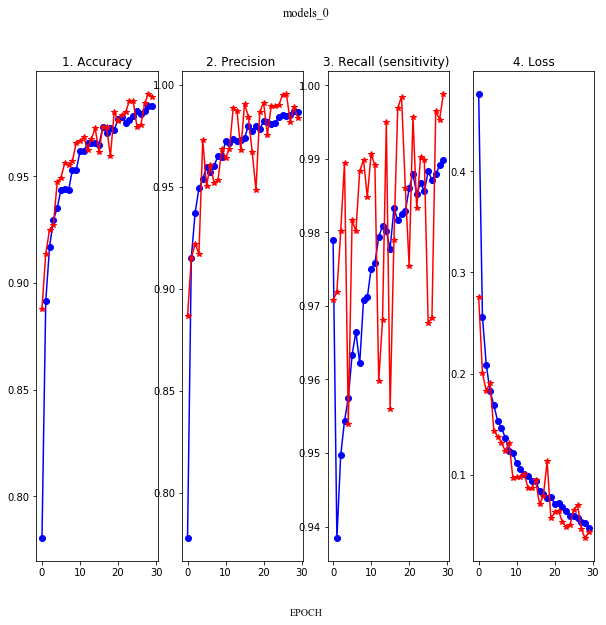

1


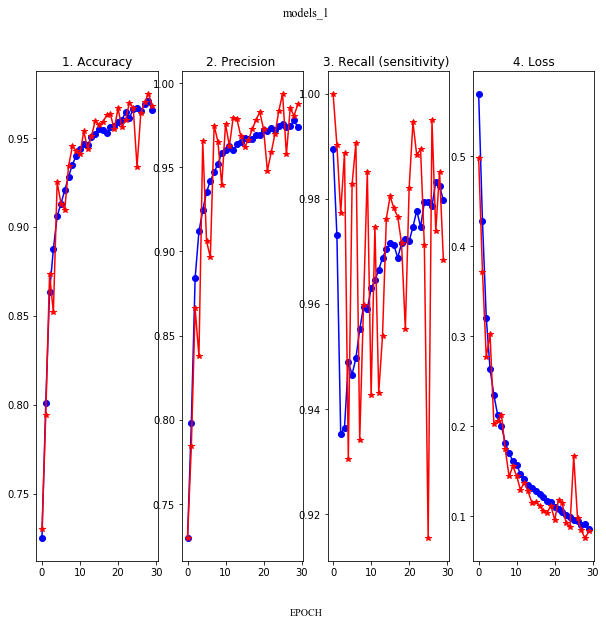

2


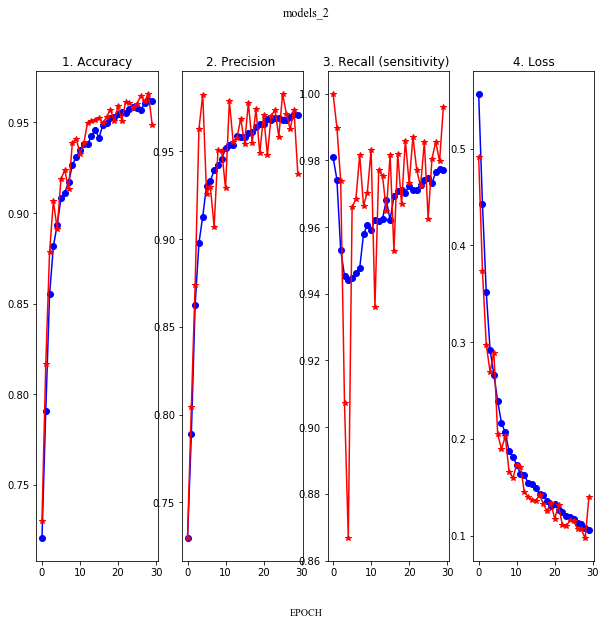

In [22]:
fit_evaluation= EVALUATE.fitting_evaluation()

Visual assessment of models above:

model_0: Accuracy and loss metrics do not show sign of overfitting. However, precision and recall showed a no apparent pattern either for correct fitting or overfitting. Recall showed high flickering on the validation set, making it challenge to judge fitting performance.

model_1: Like model_0, Accuracy and loss metrics do not show signs of overfitting; however, recall and precision, exhibited less clear pattern to judge overfitting.

model_2: One more time accuracy and loss metrics showed no signs of overfitting, they were less clear patterns in comparison with the previous models. Precision and recall were ambiguous to analyse fitting performance.

From this evaluation step, we discarded model_2. We keep model_0 and model_1 for further analysis step, "metric evaluation":

In [23]:
metric_evaluation = EVALUATE.metric_evaluation()

Model 0
Loss: 0.1311735365988742 Accuracy: 0.9624252915382385 Precision: 0.9623287916183472 Recall: 0.9871194362640381
Model 1
Loss: 0.0923367920697554 Accuracy: 0.9684031009674072 Precision: 0.9834319353103638 Recall: 0.9730679392814636
Model 2
Loss: 0.15052952639258926 Accuracy: 0.9376600980758667 Precision: 0.9277108311653137 Recall: 0.9918032884597778


From this quick metric_evaluation, we see that the model_1 exhibited lowest Loss value (0.09) than model_0 (0.13). Similarly, accuracy (97%), precision (98%) and recall (97%) were larger in the model model_1. Model_2 was discarded in the previous step.

It is also worth noticing that our accuracy increment over 96% since the data is highly imbalanced, i.e. we found a baseline for this classifier of 73%, then this 97% represents an improvement of 24% for the classification performance.

For these reasons (visually and metric evaluation), at this point we believed that model_1 (batch_size = 32) was performing better than model_0, see next step. The next step is to have a look at the ROC curves and the "threshold analysis", using out function confusion_threshold_evaluation(cutoff). Cutoff represents the decision boundary probability (Chollet 2017, Gerón 2019) for a classifier.

Prediction for model 0:
Confusion Matrix
[[284  33]
 [ 11 843]]
Classification Report
              precision    recall  f1-score   support

           1       0.96      0.90      0.93       317
           0       0.96      0.99      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.96      0.94      0.95      1171
weighted avg       0.96      0.96      0.96      1171



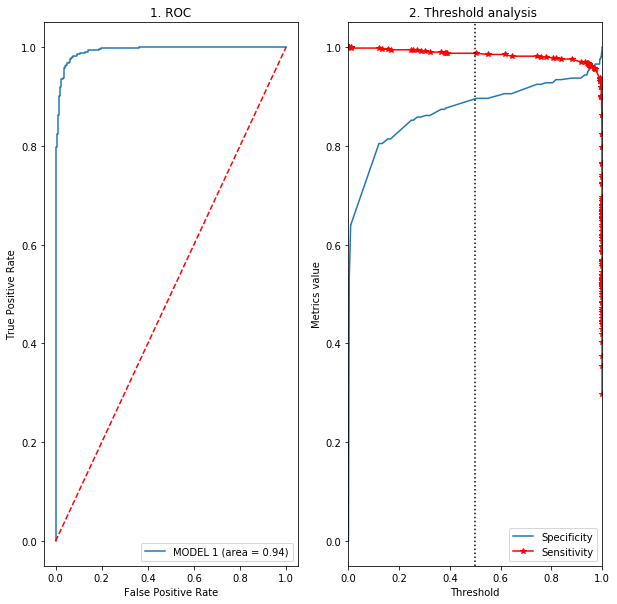

Prediction for model 1:
Confusion Matrix
[[303  14]
 [ 23 831]]
Classification Report
              precision    recall  f1-score   support

           1       0.93      0.96      0.94       317
           0       0.98      0.97      0.98       854

   micro avg       0.97      0.97      0.97      1171
   macro avg       0.96      0.96      0.96      1171
weighted avg       0.97      0.97      0.97      1171



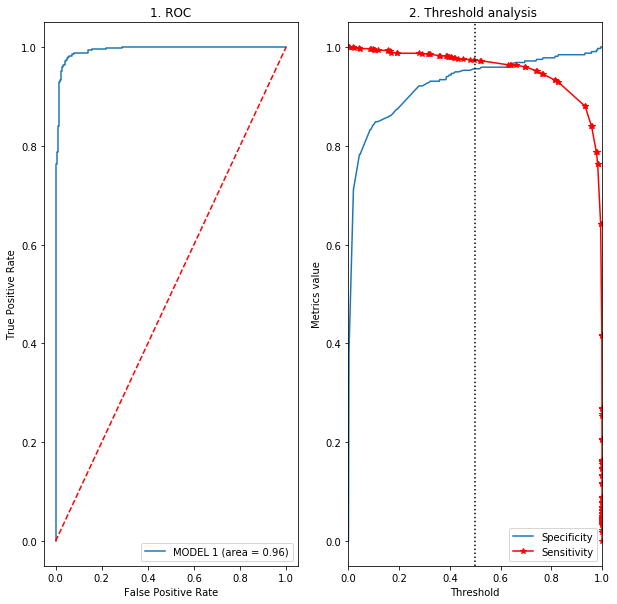

Prediction for model 2:
Confusion Matrix
[[251  66]
 [  7 847]]
Classification Report
              precision    recall  f1-score   support

           1       0.97      0.79      0.87       317
           0       0.93      0.99      0.96       854

   micro avg       0.94      0.94      0.94      1171
   macro avg       0.95      0.89      0.92      1171
weighted avg       0.94      0.94      0.94      1171



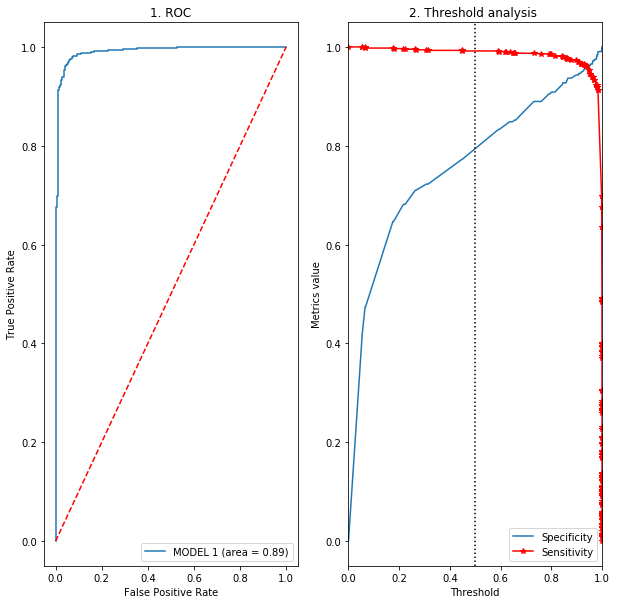

In [24]:
cutoff = 0.5 # this is the DEFAULT decision boundary probability, we will modify it later.

#3 .Call the last evaluation function:
EVALUATE.confusion_threshold_evaluation(cutoff)

Results above: We can see in the confusion matrix of model_1 that the number of true positives and true negatives is larger than in the other two models. We recognise that this model has classified the largest number of true positives (303) than model_0 (284) and model_2 (251). While the number of true negatives was the lowest (831). In addition, model_1 has an AUC = 0.96- The model_0, nevertheless, it has also a descent AUC (0.94), and has the lowest number of missclassified individuals (44), while model_1 has (37). Therefore, the AUC values was in direct agreement with the metric values obtained from the previous step which point model_1 (batch size = 32) as the best model.
The next step is the "threshold analyses" which according to Lukkarinen (2012) provides the correct model tunning to balance sensitivity and specificity. See next step.

In conclusion, it appears to be an overall trend of benefits for model_1. Then the next step is to tune model_1 changing the decision boundary probability or cut-off which seems to be located at ~ 0.7..:


In [4]:
# Loading model 0, for tunning further evaluation, i.e. changing
# cutoff = decision boundary probability

loaded_model = tf.keras.models.load_model('model1.h5') 

Confusion Matrix
[[308   9]
 [ 35 819]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.97      0.93       317
           0       0.99      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.94      0.97      0.95      1171
weighted avg       0.96      0.96      0.96      1171



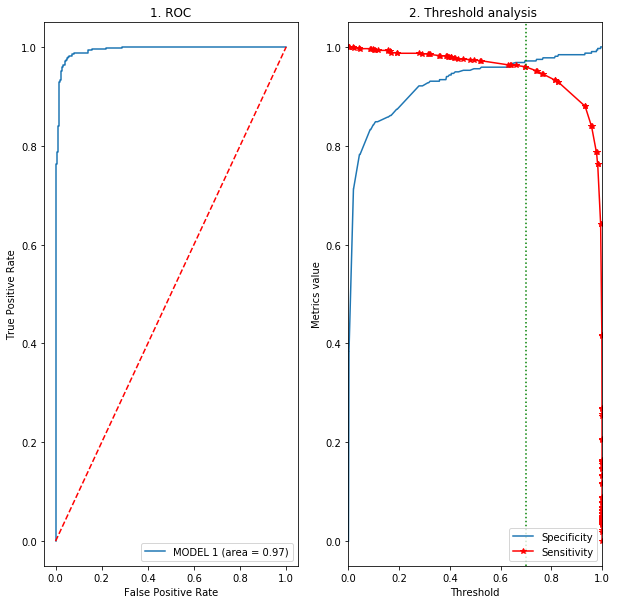

In [5]:
# First change in the decision boundary 0.5->0.7 (only for model_1)
cutoff = 0.7
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation at line 17
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

Using a desicion boundary = 0.7, we incremented the AUC to 0.97, and also the amount of true positives (5 new patients) and deacrease the numbers 
true negatives (12 lost). This is a net reduction of the correct classification of 2 patients (5 - 12 = -7 patients).
Similarly F1 scores were balance between sensitivity and specificity. It seems we should be deacreased further the cut-off to 0.66.

In [6]:
#test_generator.class_indices

Confusion Matrix
[[307  10]
 [ 33 821]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.97      0.93       317
           0       0.99      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.95      0.96      0.95      1171
weighted avg       0.96      0.96      0.96      1171



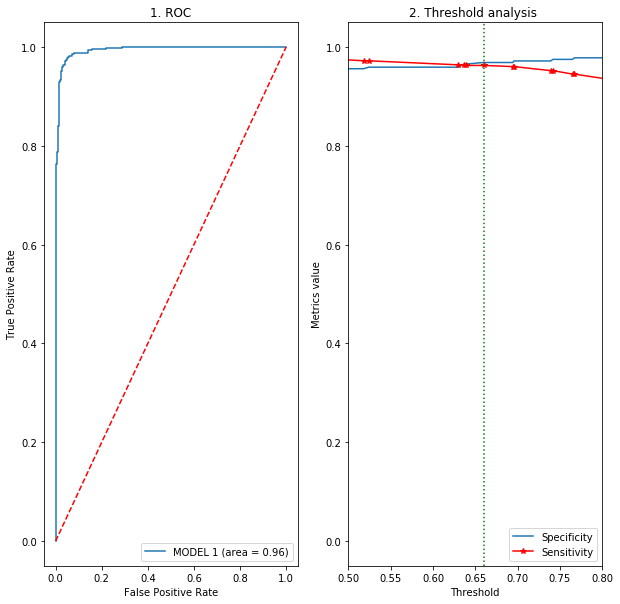

In [9]:
cutoff = 0.66 # incrementing the decision boundary from 0.66
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0.5, 0.8])
axs[1].legend(loc="lower right")

plt.show()       

The results above showed that the true negatives reduced in 10 patients. In contrast, the true positive numbers were incremented in 4 patients; this gives a net gaining of (4 - 13 = 9 new correctly identified patients). It seems the model becomes improve in the detection of sick people. We tried to zoom in the threshold analyses (0.5-0.8 x axis) and this show that the balance between sensitivity and specificity should be a cut-off, e.g. 0.64:

Confusion Matrix
[[307  10]
 [ 32 822]]
Classification Report
              precision    recall  f1-score   support

           1       0.91      0.97      0.94       317
           0       0.99      0.96      0.98       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.95      0.97      0.96      1171
weighted avg       0.97      0.96      0.96      1171



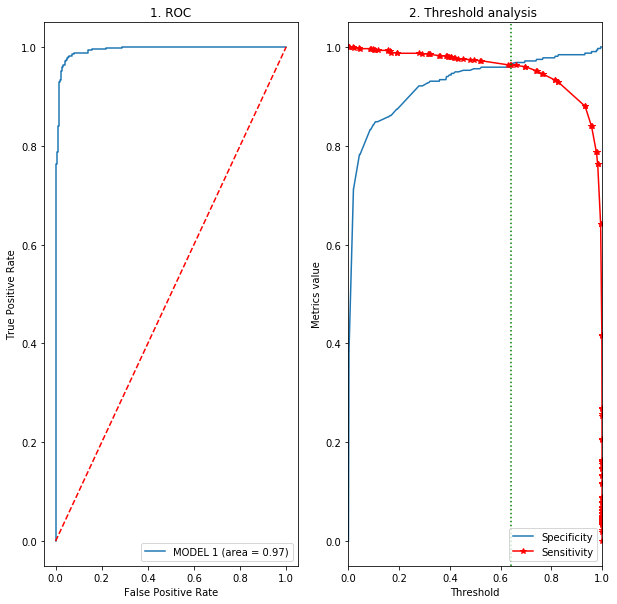

In [10]:
cutoff = 0.64 # we reduce the "decision boundary" from 0.5 -> 0.64
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

 With this decision boundary (0.64), we immediately increased the AUC to 0.97; additionally, we increased the number of true positives by 4 patients. Threshold analysis showed a visual "optimal" balance between sensitivity and specificity. 
 Only for learning purposes we set the cut-off to 0.3:


Confusion Matrix
[[294  23]
 [ 12 842]]
Classification Report
              precision    recall  f1-score   support

           1       0.96      0.93      0.94       317
           0       0.97      0.99      0.98       854

   micro avg       0.97      0.97      0.97      1171
   macro avg       0.97      0.96      0.96      1171
weighted avg       0.97      0.97      0.97      1171



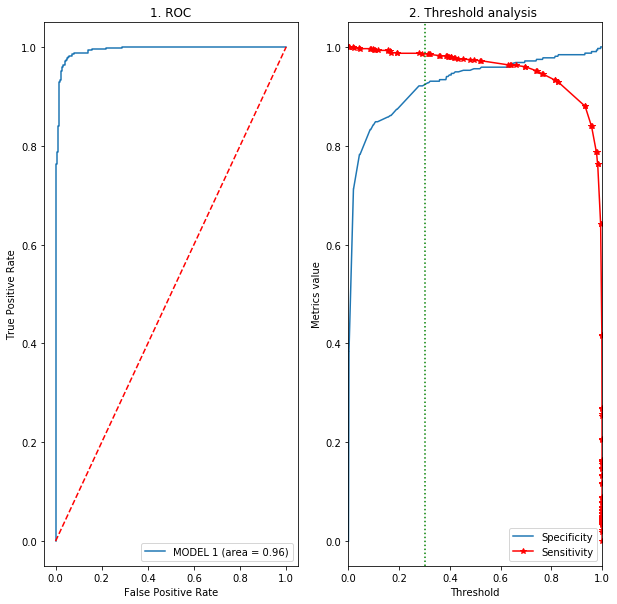

In [12]:
cutoff = 0.3 
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

With this decision boundary (0.3), we immediately decreased the number of true positives by 9 patients and increased the number of true negatives by 11 patients Threshold analysis showed an imbalance between sensitivity and specificity at this threshold. What this cut-off did is increment the number of false negatives in exactly 9 patients. 


IV. Discusion

In this work, we built a classifier testing three CNNs each one with a different batch size. We learnt that batch size influences the training time, making it longer as the batch becomes smaller. We also observed that metrics achieved by the model also slightly change (accuracy, precision, recall, F1). For example, our models achieved the similar accuracy, precision and recall. Gerón (2019) indicates that there is no general rule of thumb as to which batch size works out best, this agrees with Chollet (2017) who suggested to try few batch sizes and pick the one which generate sensitive results. Nevertheless, both authors agree on not to use large batch sizes since they tend to over fit the data, as we also see with our model_2 (batch size 64).

"Accuracy" and especially "loss" metrics are more reliable in evaluating the fitting performance of models than precision and recall. Recall/or sensitivity (also called the true positive rate) measures the proportion of actual positives that correctly identifies. At the same time, specificity (also called the true negative rate) measures the ratio of real negatives that are correctly identified as such. Therefore, a sound classifier should maximise the balance of true positive rate (sensitivity) and true negative rate (specificity), and this should reduce the total of misclassified patients. 
Here we examined several threshold analyses plots and found that our model with a batch size = 32, and cut-off = 0.64 performed best, we gained high accuracy (over 97%) and sensitivity, specifity and F1 scores over 96%. It is worth noticing that increment the decision boundary probability make the classifier more and more strict in the detection of true positive cases at the cost of increasing the number of false negatives. The decision boundary is a critical step for the use and purpose of the classifier. For example, if a pandemic disease tends to quickly spreads, e.g. coronavirus, a strict decision boundary probability should be used.
Fitting CNN is a daunting task for inexperience analysts.

V. Bibliography

Chollet, F. 2017. Deep Learning with Python. Manning Publications Co. USA. 384 pages

Gerón, A. 2019. Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media Inc. Sebastopol, CA, USA. 484 pages.

Hoorne, D. 2017. Python Machine Learning Case Studies. Apress.editors. Karachi, Pakistan, 205 pages.

Lukkarinen, S. 2012. Phonocardiography: Development of a clinical system and its application to screening for paediatric heart murmurs. Doctoral Disseration 128 pages

